In [41]:
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import *
from keras.applications import MobileNet,imagenet_utils
from keras.preprocessing import image
from keras.models import load_model


In [169]:
count = 1

def rotate(image):
    img = cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img
    
def FrameCapture(path):
    #print("inside")
    cap = cv2.VideoCapture(path)
    #print("Cap")
    while (cap.isOpened()):
        #print("cap open")
        ret, frame = cap.read()
        global count
        if ret:
            img = rotate(frame)
            print("Read %d frame: " % count, ret)
            cv2.imwrite("./Train/Aadhar/Aadhar %d.jpg" % count, img)  
            count += 1
        else:
            break
 
    
    cap.release()
    cv2.destroyAllWindows()
 
    
    


In [53]:
FrameCapture("./voter1.mp4")

Read 81 frame:  True
Read 82 frame:  True
Read 83 frame:  True
Read 84 frame:  True


## MODEL

In [2]:
Classes = ['Aadhar Card','Driving Licence','PAN','Passport','Voter ID']

In [204]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range=0.2,zoom_range=0.2,
                                   fill_mode = 'nearest')

valid_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [208]:
train_generator = train_datagen.flow_from_directory(directory = './Train/',
                                                   target_size = (100,100),
                                                   batch_size = 32,
                                                   class_mode = 'categorical')

validation_generator = valid_datagen.flow_from_directory(directory = './Validation/',
                                                   target_size = (100,100),
                                                   batch_size = 32,
                                                   class_mode = 'categorical')



Found 8486 images belonging to 5 classes.
Found 1177 images belonging to 5 classes.


In [22]:
model1 = MobileNet(input_shape=(100,100,3), alpha=0.25, depth_multiplier=1, dropout=1e-3, include_top=True, weights=None, input_tensor=None, pooling=None, classes=5)

In [23]:
model1.summary()

Model: "mobilenet_0.25_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 8)         216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 8)  

In [209]:
model1.compile(optimizer = Adam(),loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [211]:
model1.fit_generator(train_generator,steps_per_epoch=500,epochs=20,validation_data=validation_generator,
                    validation_steps=300, use_multiprocessing= True, workers=2)

Epoch 1/20
500/500 [==============================] - 301s 603ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 4.4062e-05 - val_accuracy: 1.0000
Epoch 2/20
500/500 [==============================] - 300s 600ms/step - loss: 0.0084 - accuracy: 0.9972 - val_loss: 0.0506 - val_accuracy: 0.9761
Epoch 3/20
500/500 [==============================] - 304s 609ms/step - loss: 0.0127 - accuracy: 0.9970 - val_loss: 2.1579e-05 - val_accuracy: 1.0000
Epoch 4/20
500/500 [==============================] - 306s 613ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 1.4148e-05 - val_accuracy: 1.0000
Epoch 5/20
500/500 [==============================] - 310s 620ms/step - loss: 6.6200e-04 - accuracy: 0.9999 - val_loss: 8.0081e-05 - val_accuracy: 1.0000
Epoch 6/20
499/500 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991

Process ForkPoolWorker-473:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/hp/.local/lib/python3.6/site-packages/keras/utils/data_utils.py", line 406, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/hp/.local/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
  File "/home/hp/.local/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)
  File "/home/hp/.local/lib/python3.6/site-packages/keras_preprocessing/image/utils.py", line 132, in load_img
    img = img.resize(width_

In [350]:
model1.save(filepath="./Doc_Classification.h5")

## Using the model to predict 

In [3]:
model1 = load_model("Doc_Classification.h5")

In [10]:
def prepare(filepath):
    image = cv2.imread(filepath)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    new_img = img/255.
    new_image = cv2.resize(new_img,(100,100))
    return new_image.reshape(-1, 100, 100, 3)

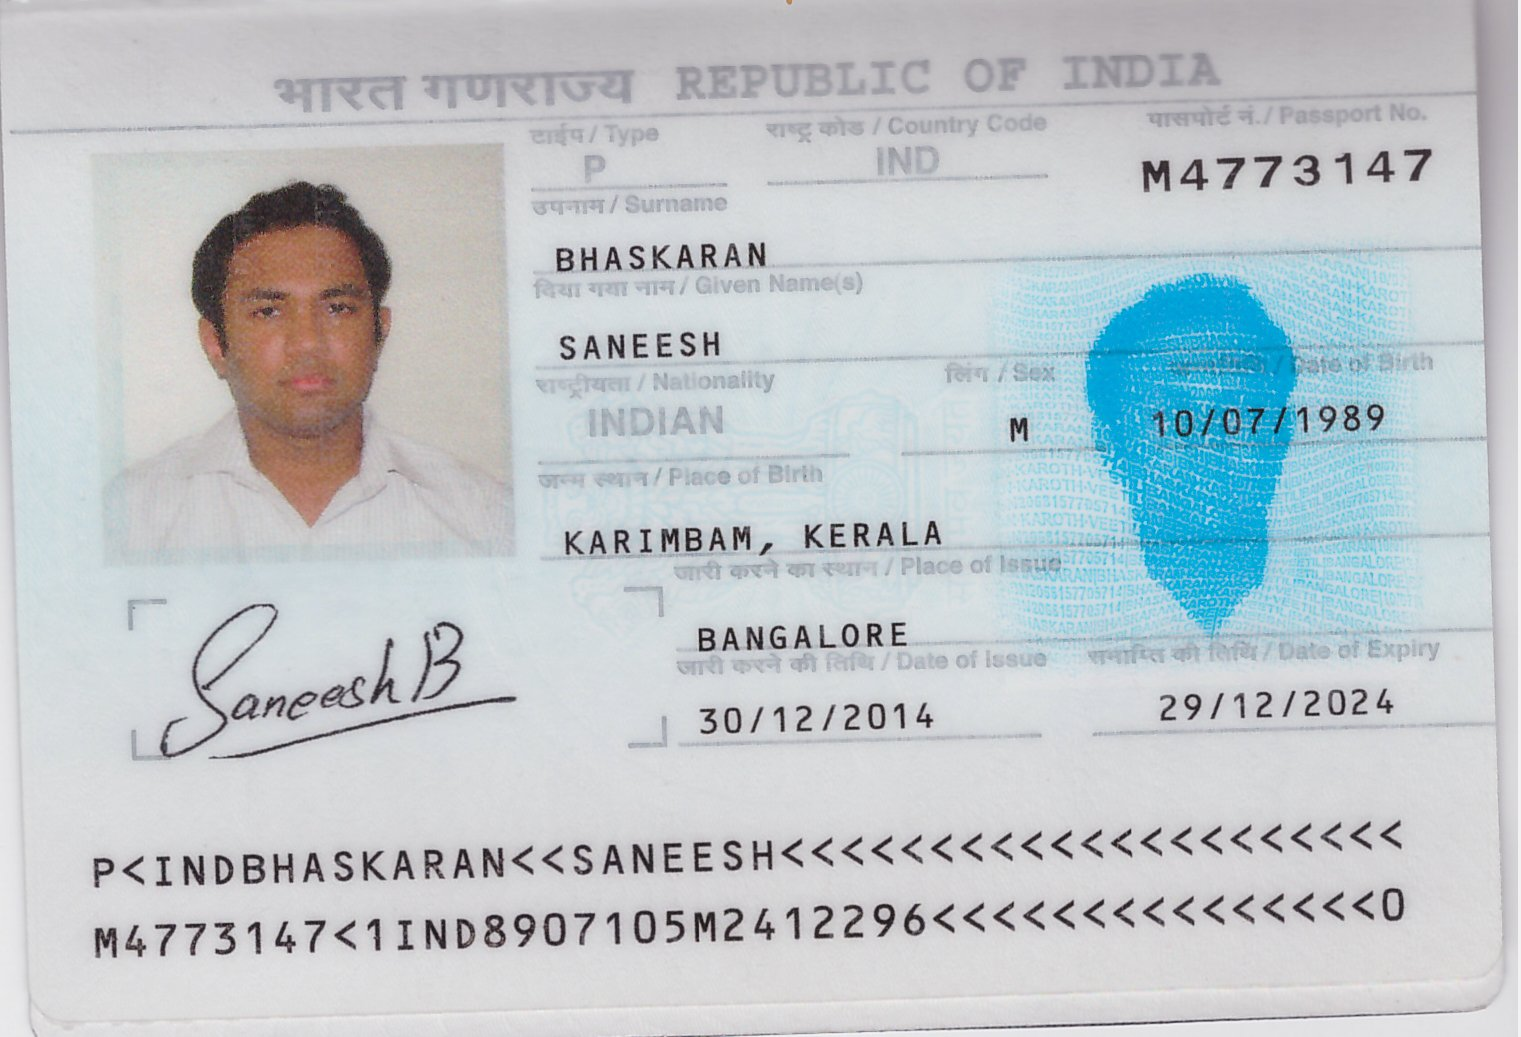

In [5]:
from IPython.display import Image
Image(filename= "./Test/INDIA_PASSPORT_FRONT_1.jpg", width = 300, height = 200)

In [11]:
result = model1.predict([prepare("./Test/INDIA_PASSPORT_FRONT_1.jpg")])
print(result[0])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")


[6.6093735e-11 1.1387022e-10 2.2517337e-12 1.0000000e+00 9.3939526e-12]
Passport :  100.0 %


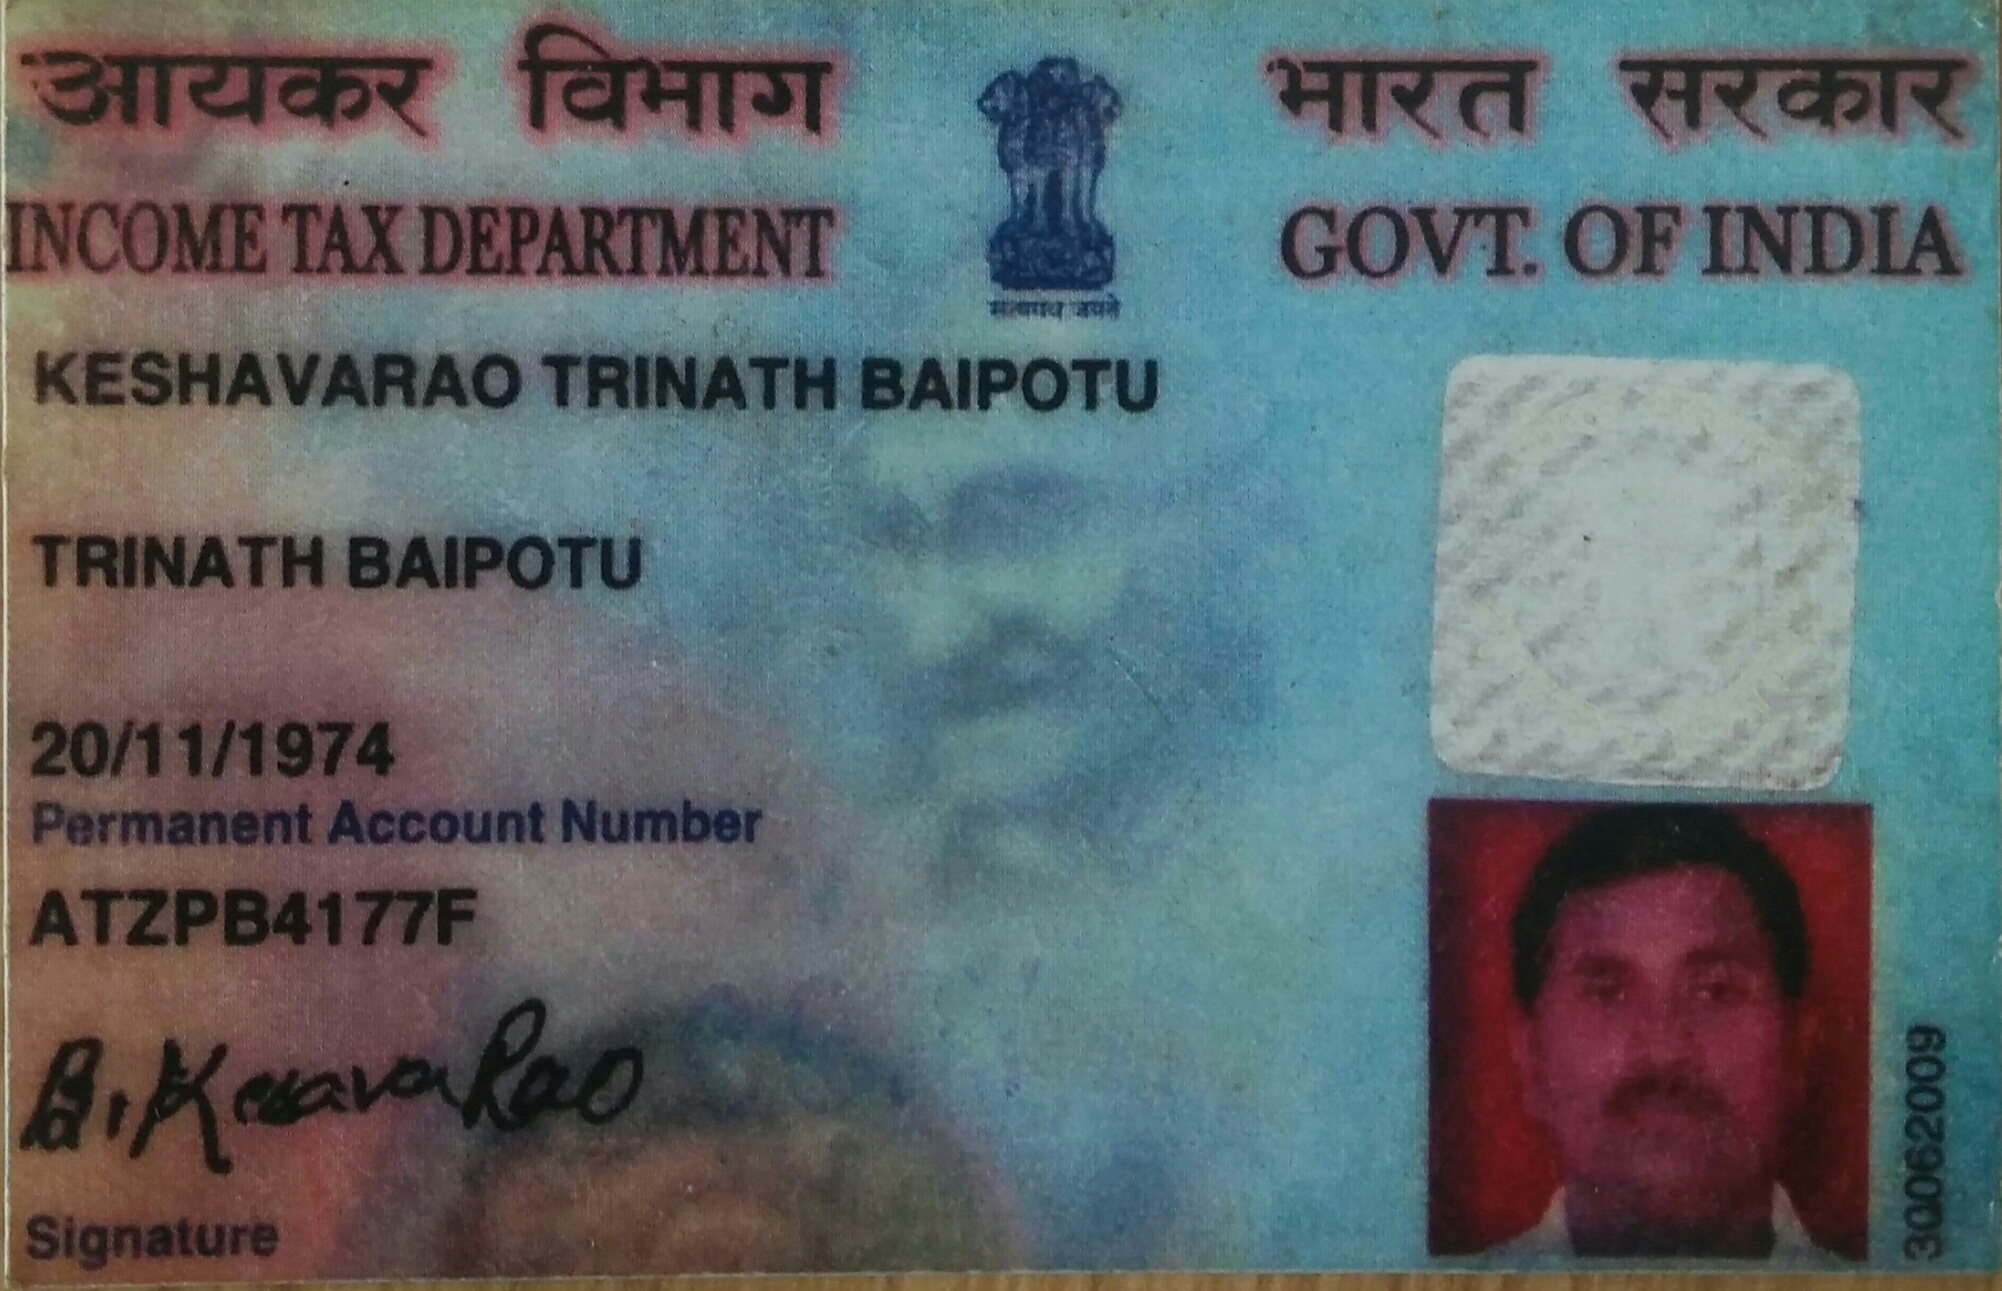

In [7]:
Image(filename = "./Test/attachments/IMG_20200116_112254_01_01.jpg", width=200, height=400)

In [39]:
result = model1.predict([prepare("./Test/attachments/IMG_20200116_112254_01_01.jpg")])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")


Aadhar Card :  99.99 %


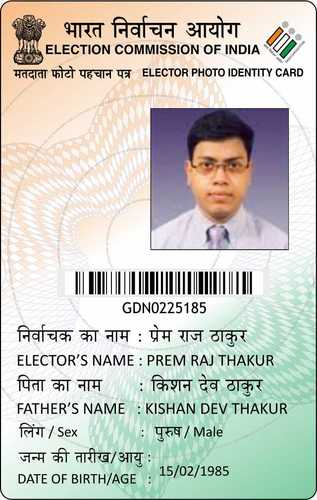

In [14]:
Image(filename = "./Test/voter1.jpg", width=200, height=400)

In [13]:
result = model1.predict([prepare("./Test/voter1.jpg")])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")


Voter ID :  100.0 %


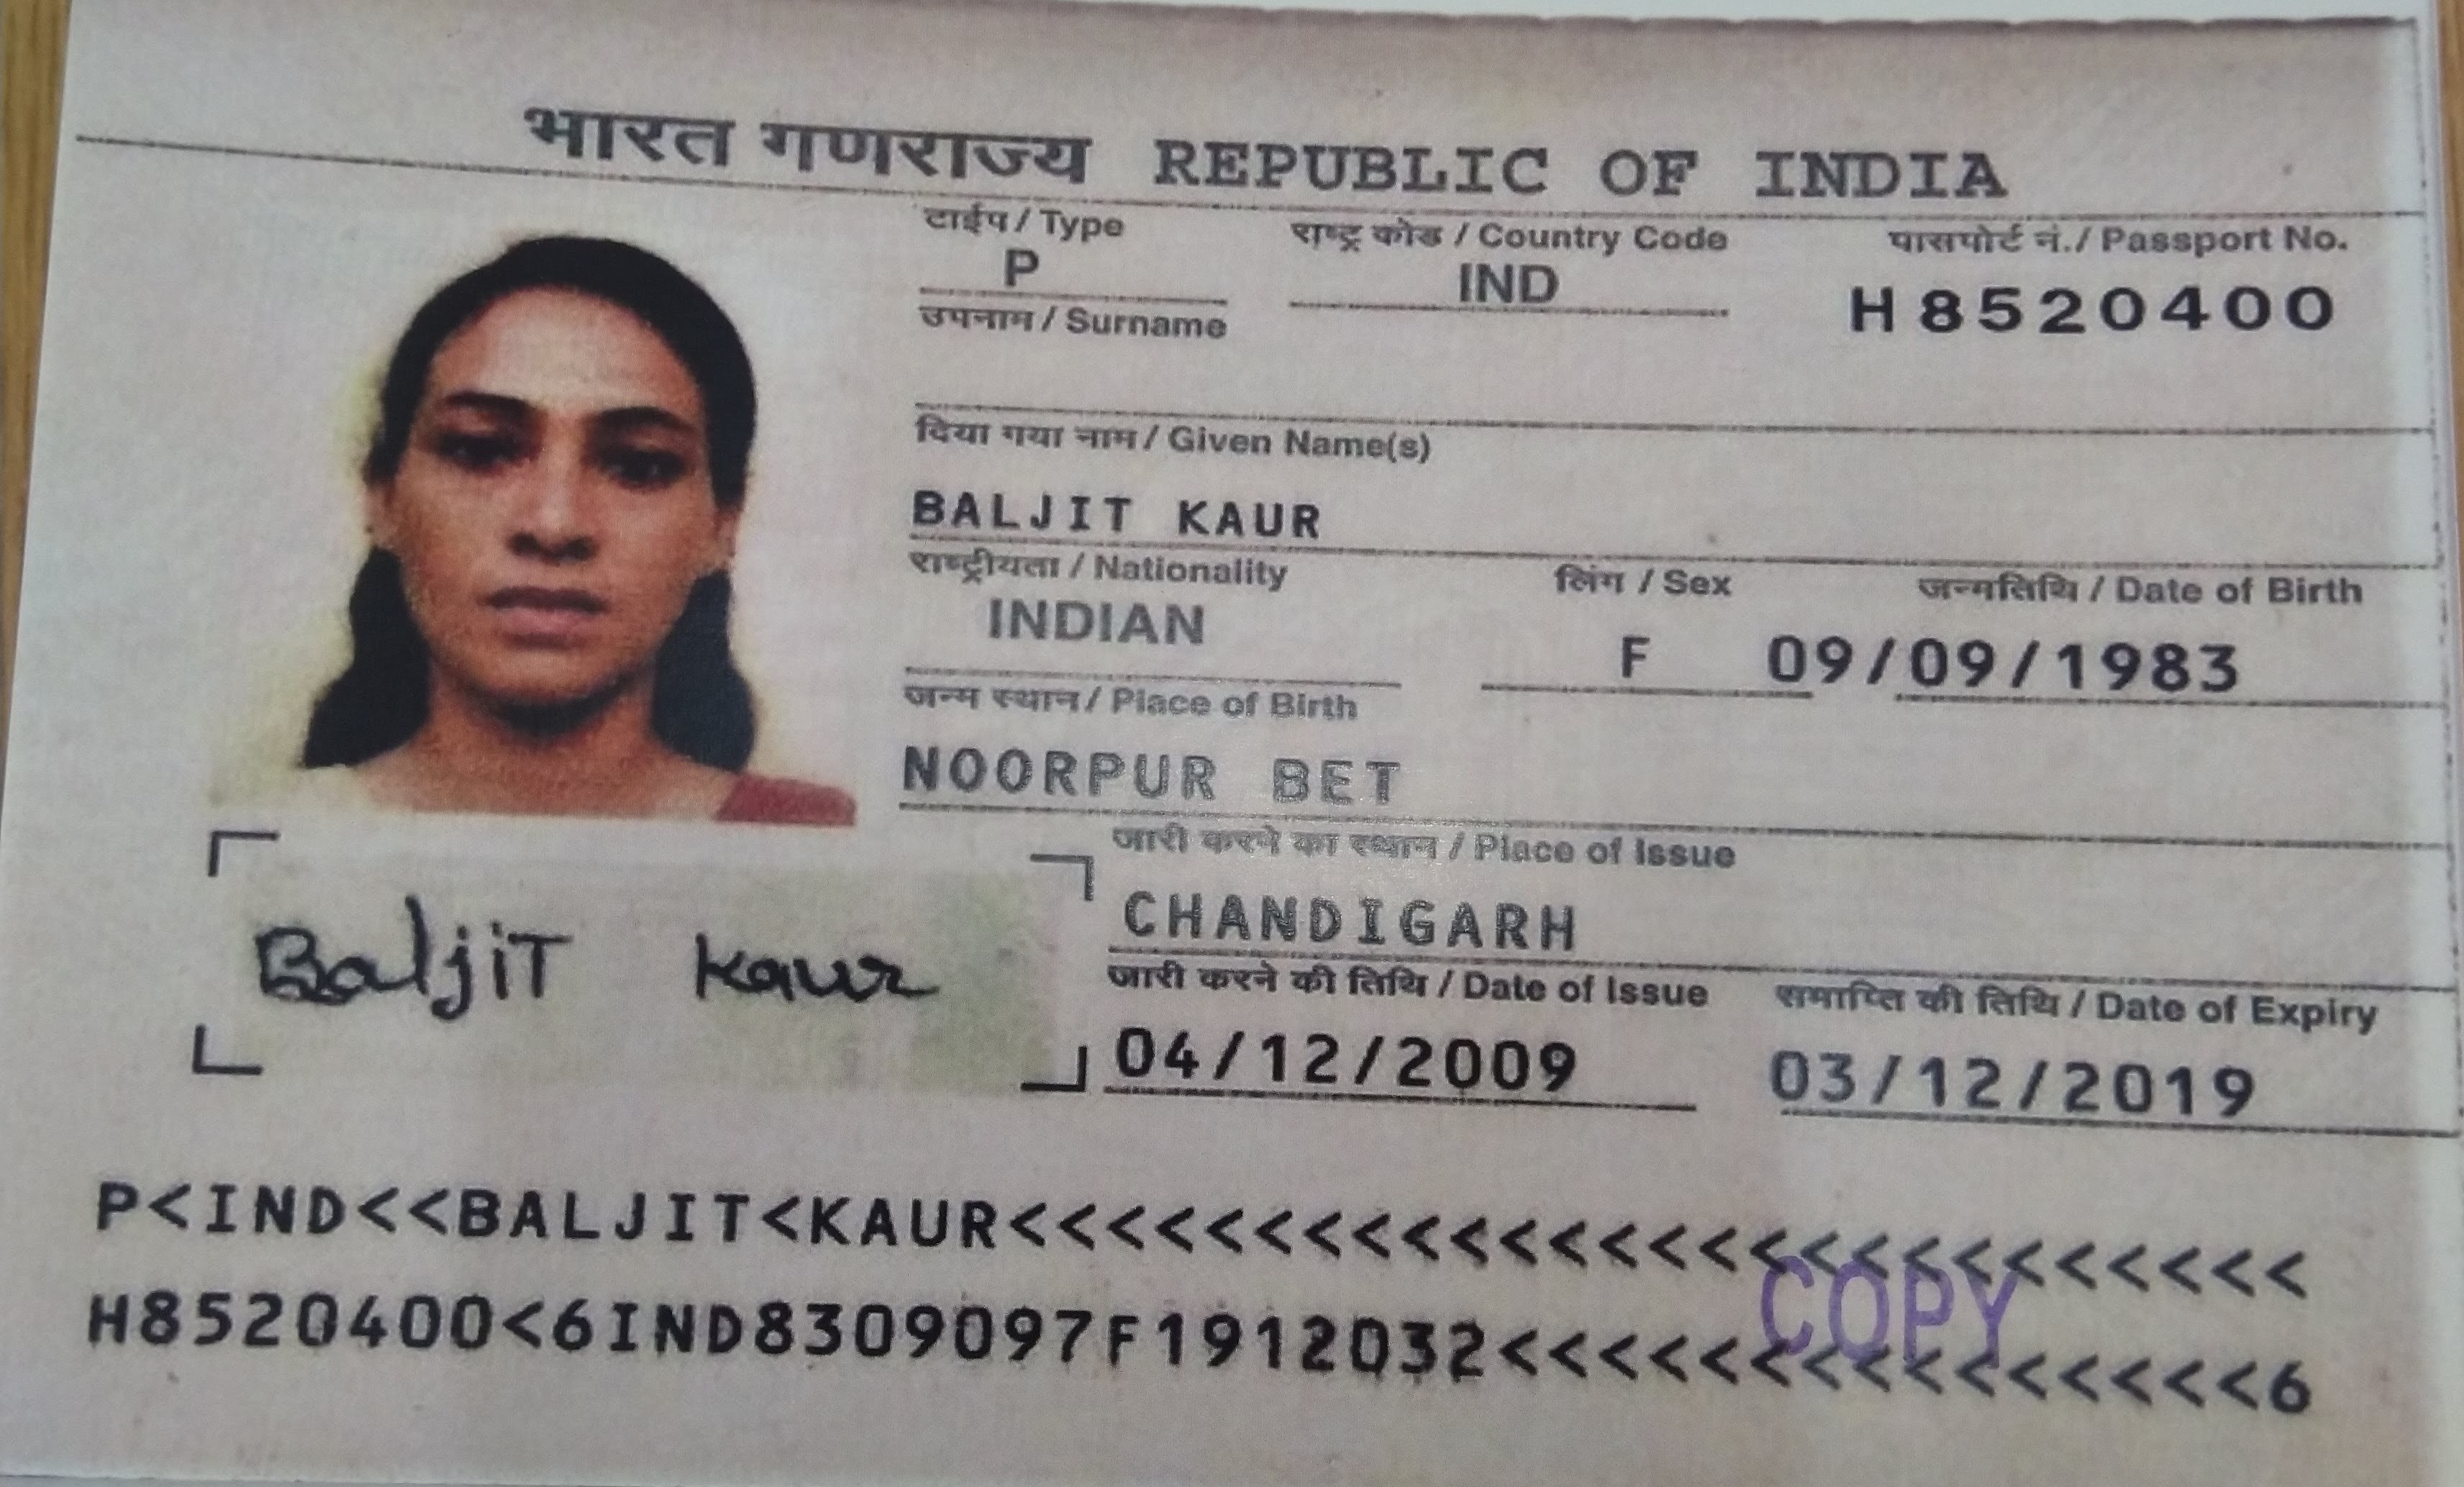

In [16]:
Image(filename = "./Test/INDIA_PASSPORT_FRONT_2.jpg", width=400, height=300)

In [14]:
result = model1.predict([prepare("./Test/INDIA_PASSPORT_FRONT_2.jpg")])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

Driving Licence :  97.16 %


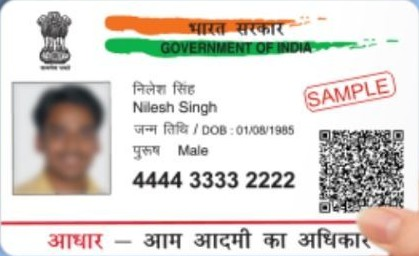

In [20]:
Image(filename = "./Test/Aadhar-Card-Correction-Form.jpg", width=400, height=300)

In [16]:
result = model1.predict([prepare("./Test/Aadhar-Card-Correction-Form.jpg")])
print(result)
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[[1.0000000e+00 4.7114518e-10 9.0211102e-12 1.0346187e-11 1.1885974e-10]]
Aadhar Card :  100.0 %


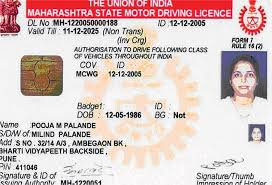

In [22]:
Image(filename = "./Test/DL1.jpeg", width=400, height=300)

In [17]:
result = model1.predict([prepare("./Test/DL1.jpeg")])
print(result)
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[[2.1675596e-06 9.9999774e-01 4.6780562e-11 8.1946588e-08 4.9306146e-09]]
Driving Licence :  100.0 %


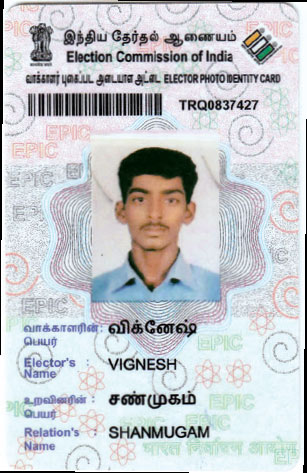

In [25]:
Image(filename = "./Test/voter2.jpg", width=200, height=300)

In [26]:
result = model1.predict([prepare("./Test/voter2.jpg")])
print(result)
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[[7.5395562e-04 1.1421042e-06 2.3296423e-05 5.3962871e-05 9.9916768e-01]]
Voter ID :  99.92 %


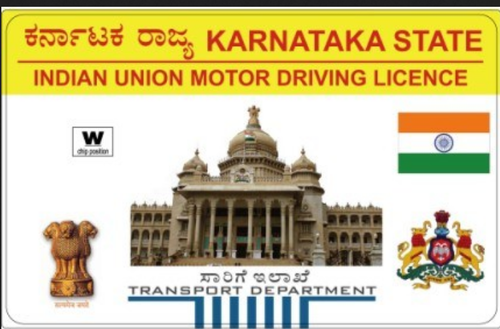

In [26]:
Image(filename = "./Test/DL3.png", width=400, height=300)

In [19]:
result = model1.predict([prepare("./Test/DL3.png")])
print(result[0])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[3.3916063e-08 1.0000000e+00 3.8337378e-10 1.2725506e-09 3.9755942e-12]
Driving Licence :  100.0 %


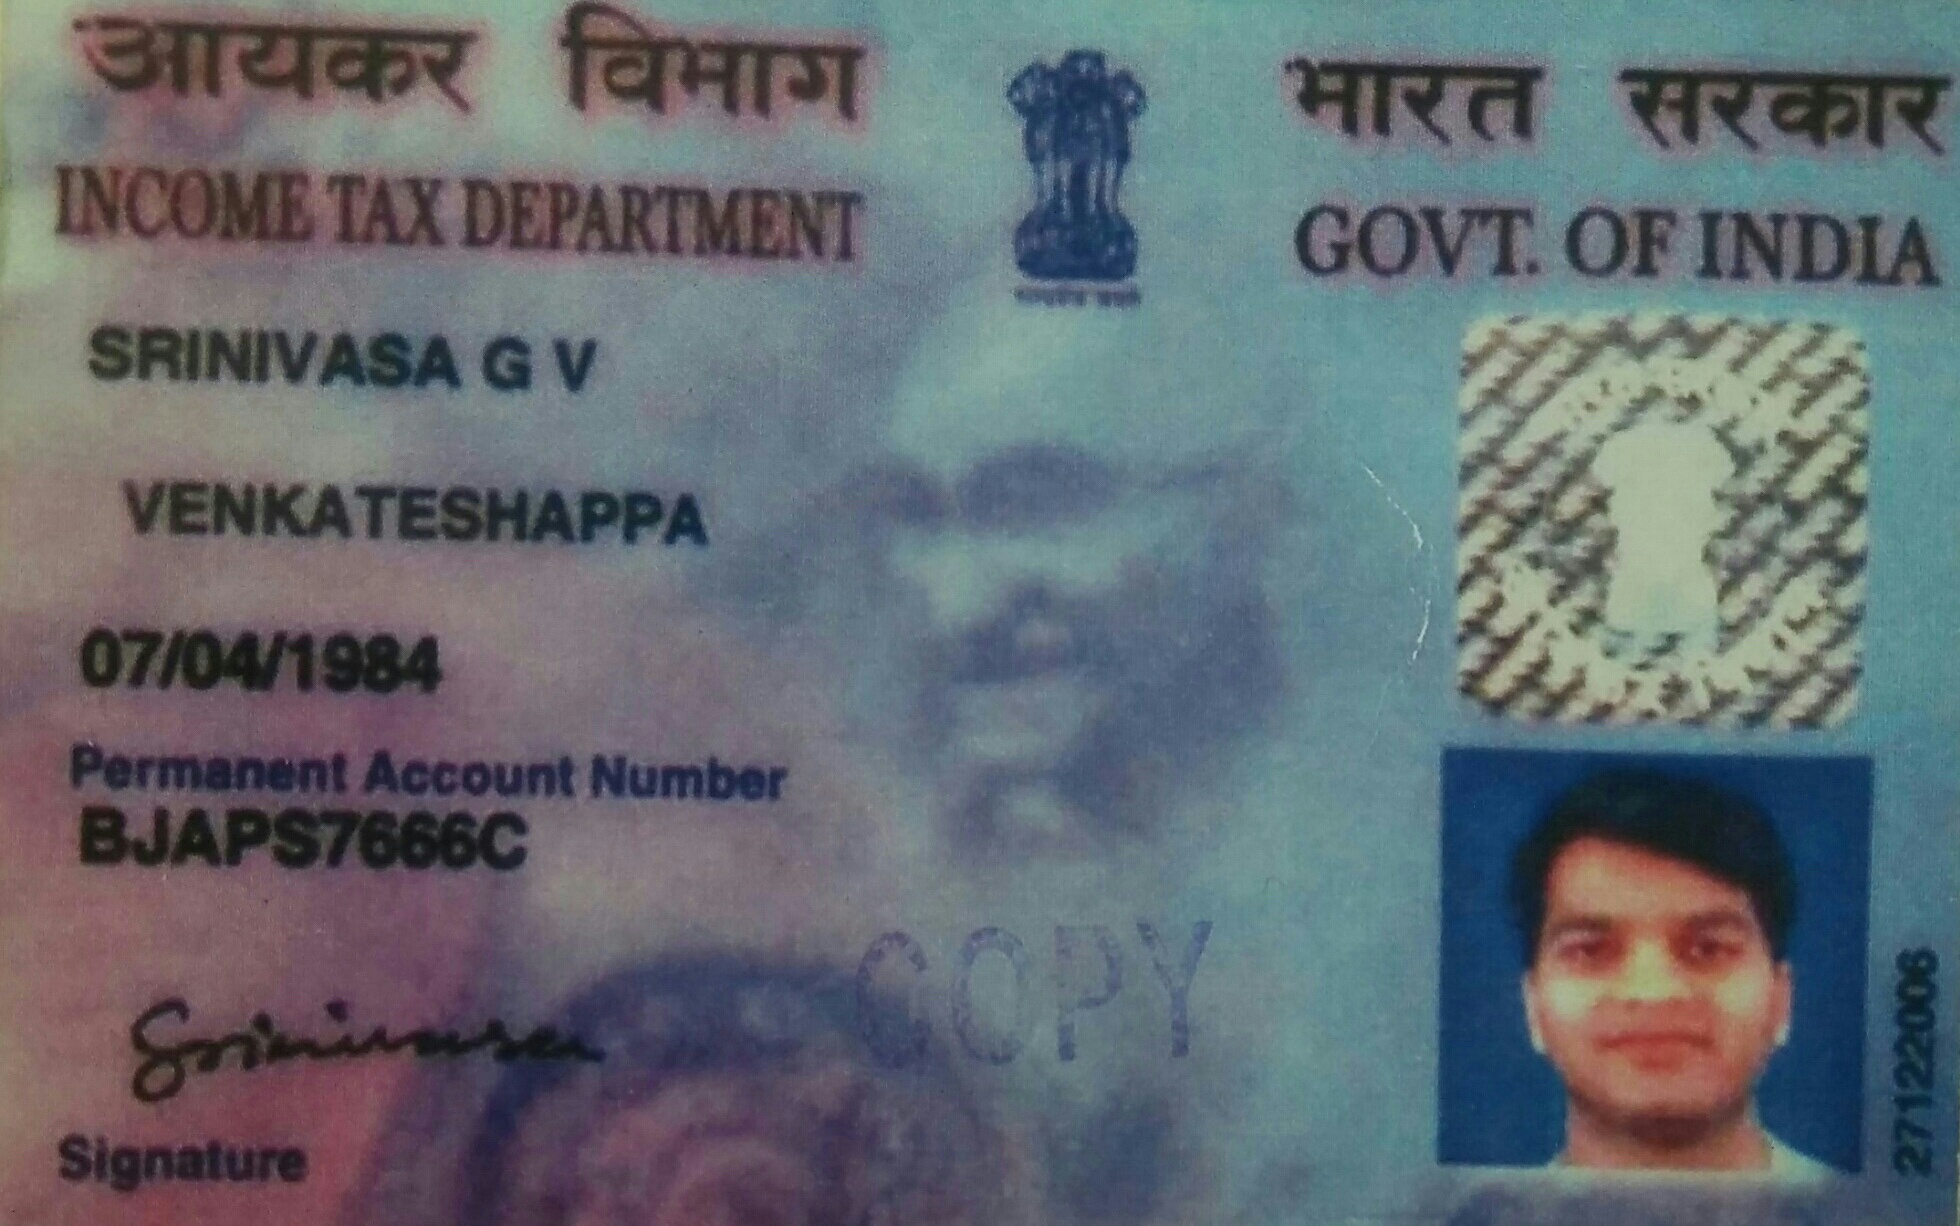

In [29]:
Image(filename = "./Test/attachments/IMG_20200116_112301_01_01_01.jpg", width=400, height=300)

In [23]:
result = model1.predict([prepare("./Test/attachments/IMG_20200116_112301_01_01_01.jpg")])
print(result[0])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[3.5518483e-04 2.2697190e-04 9.9938869e-01 3.8143322e-10 2.9189454e-05]
PAN :  99.94 %


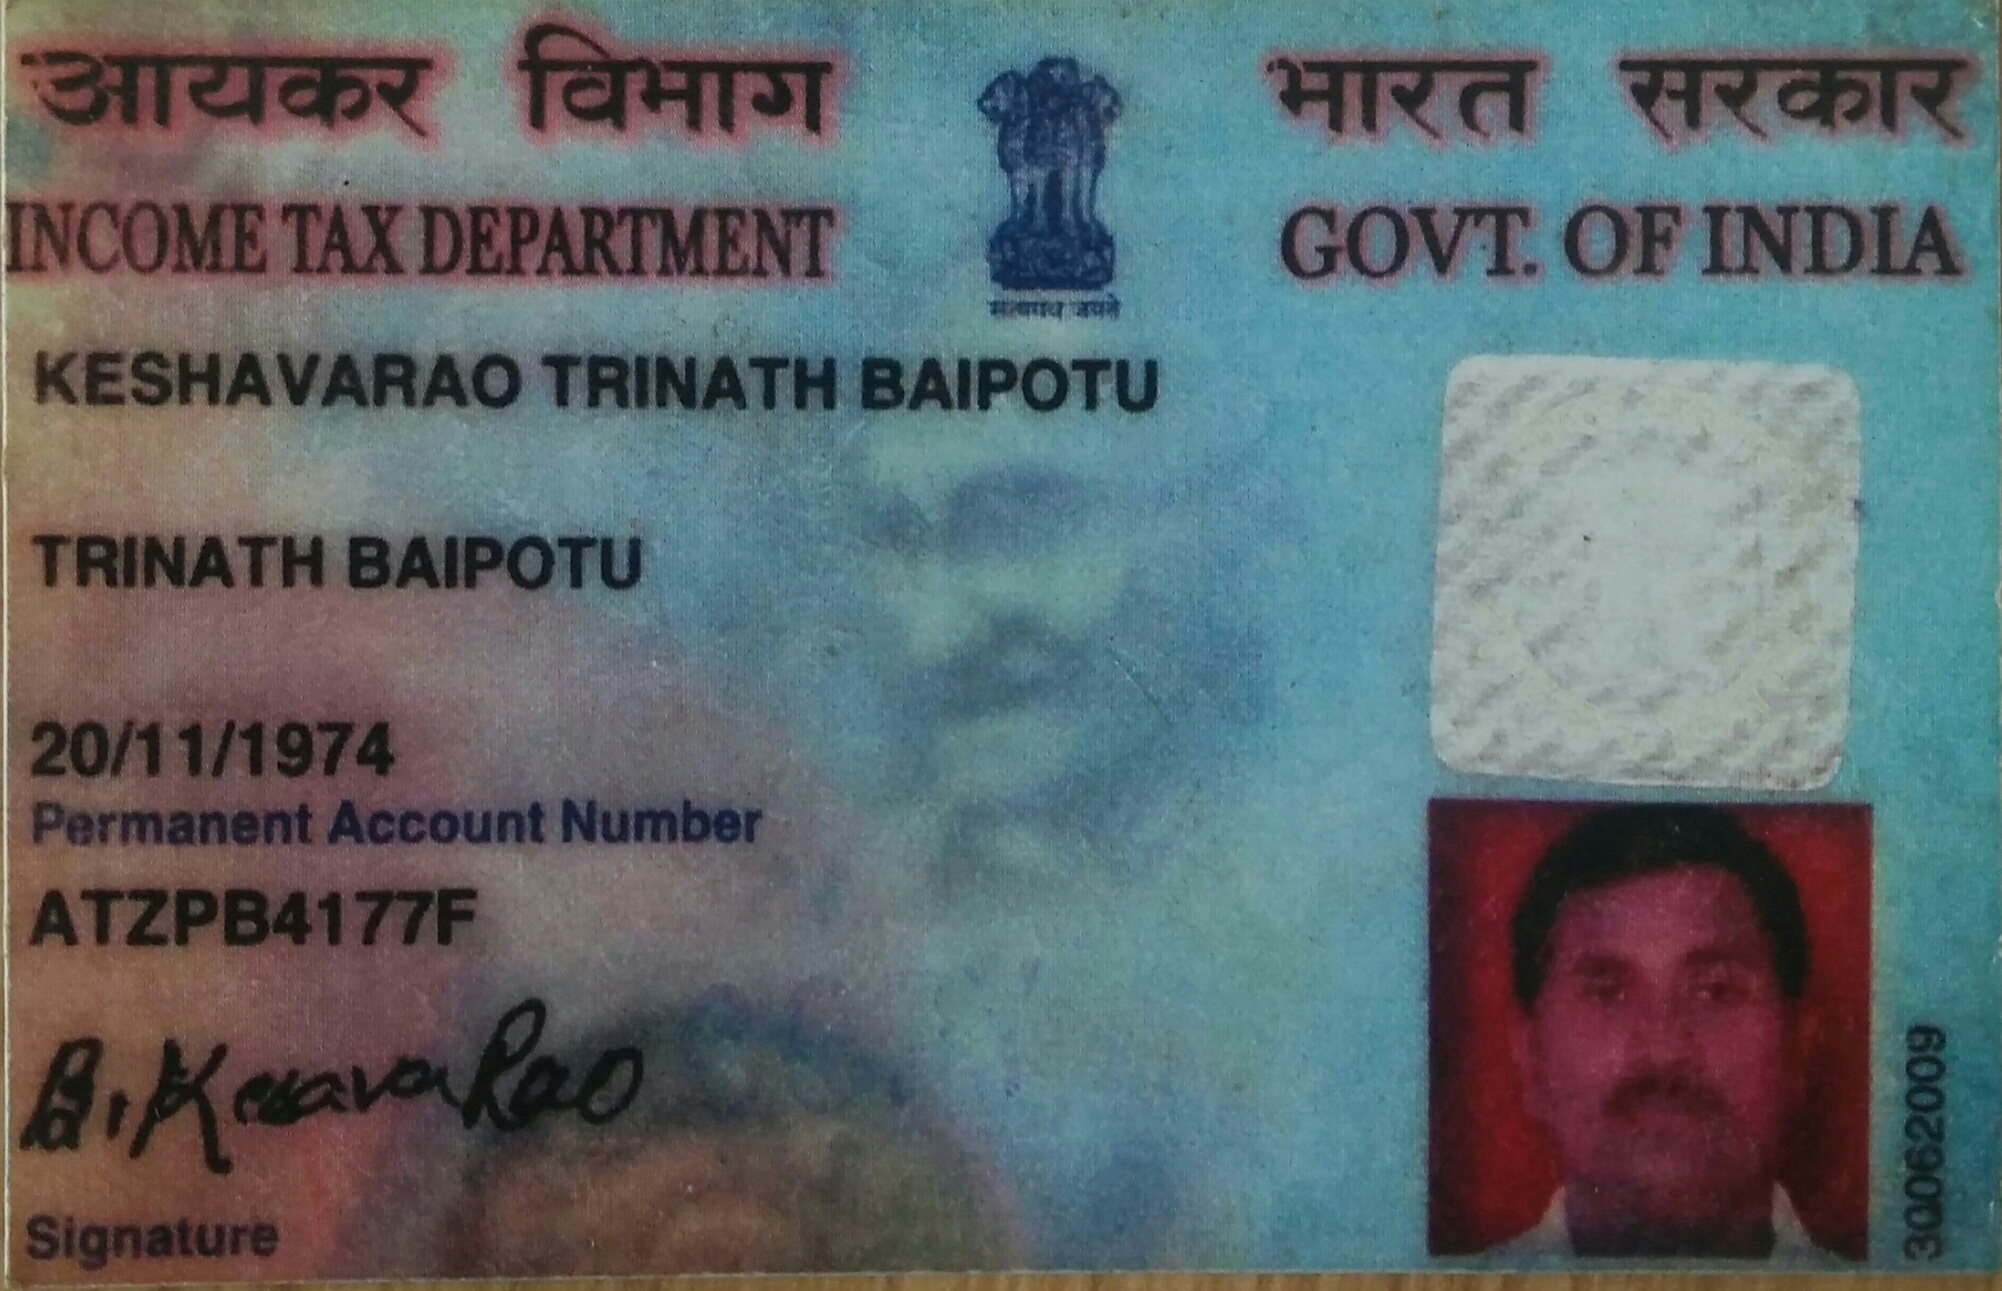

In [27]:
Image(filename = "./Test/attachments/IMG_20200116_112254_01_01.jpg", width=400, height=300)

In [29]:
result = model1.predict([prepare("./Test/attachments/IMG_20200116_112254_01_01.jpg")])
print(result[0])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[9.9994230e-01 3.0002457e-06 5.4117460e-05 1.7214800e-10 6.1389528e-07]
Aadhar Card :  99.99 %


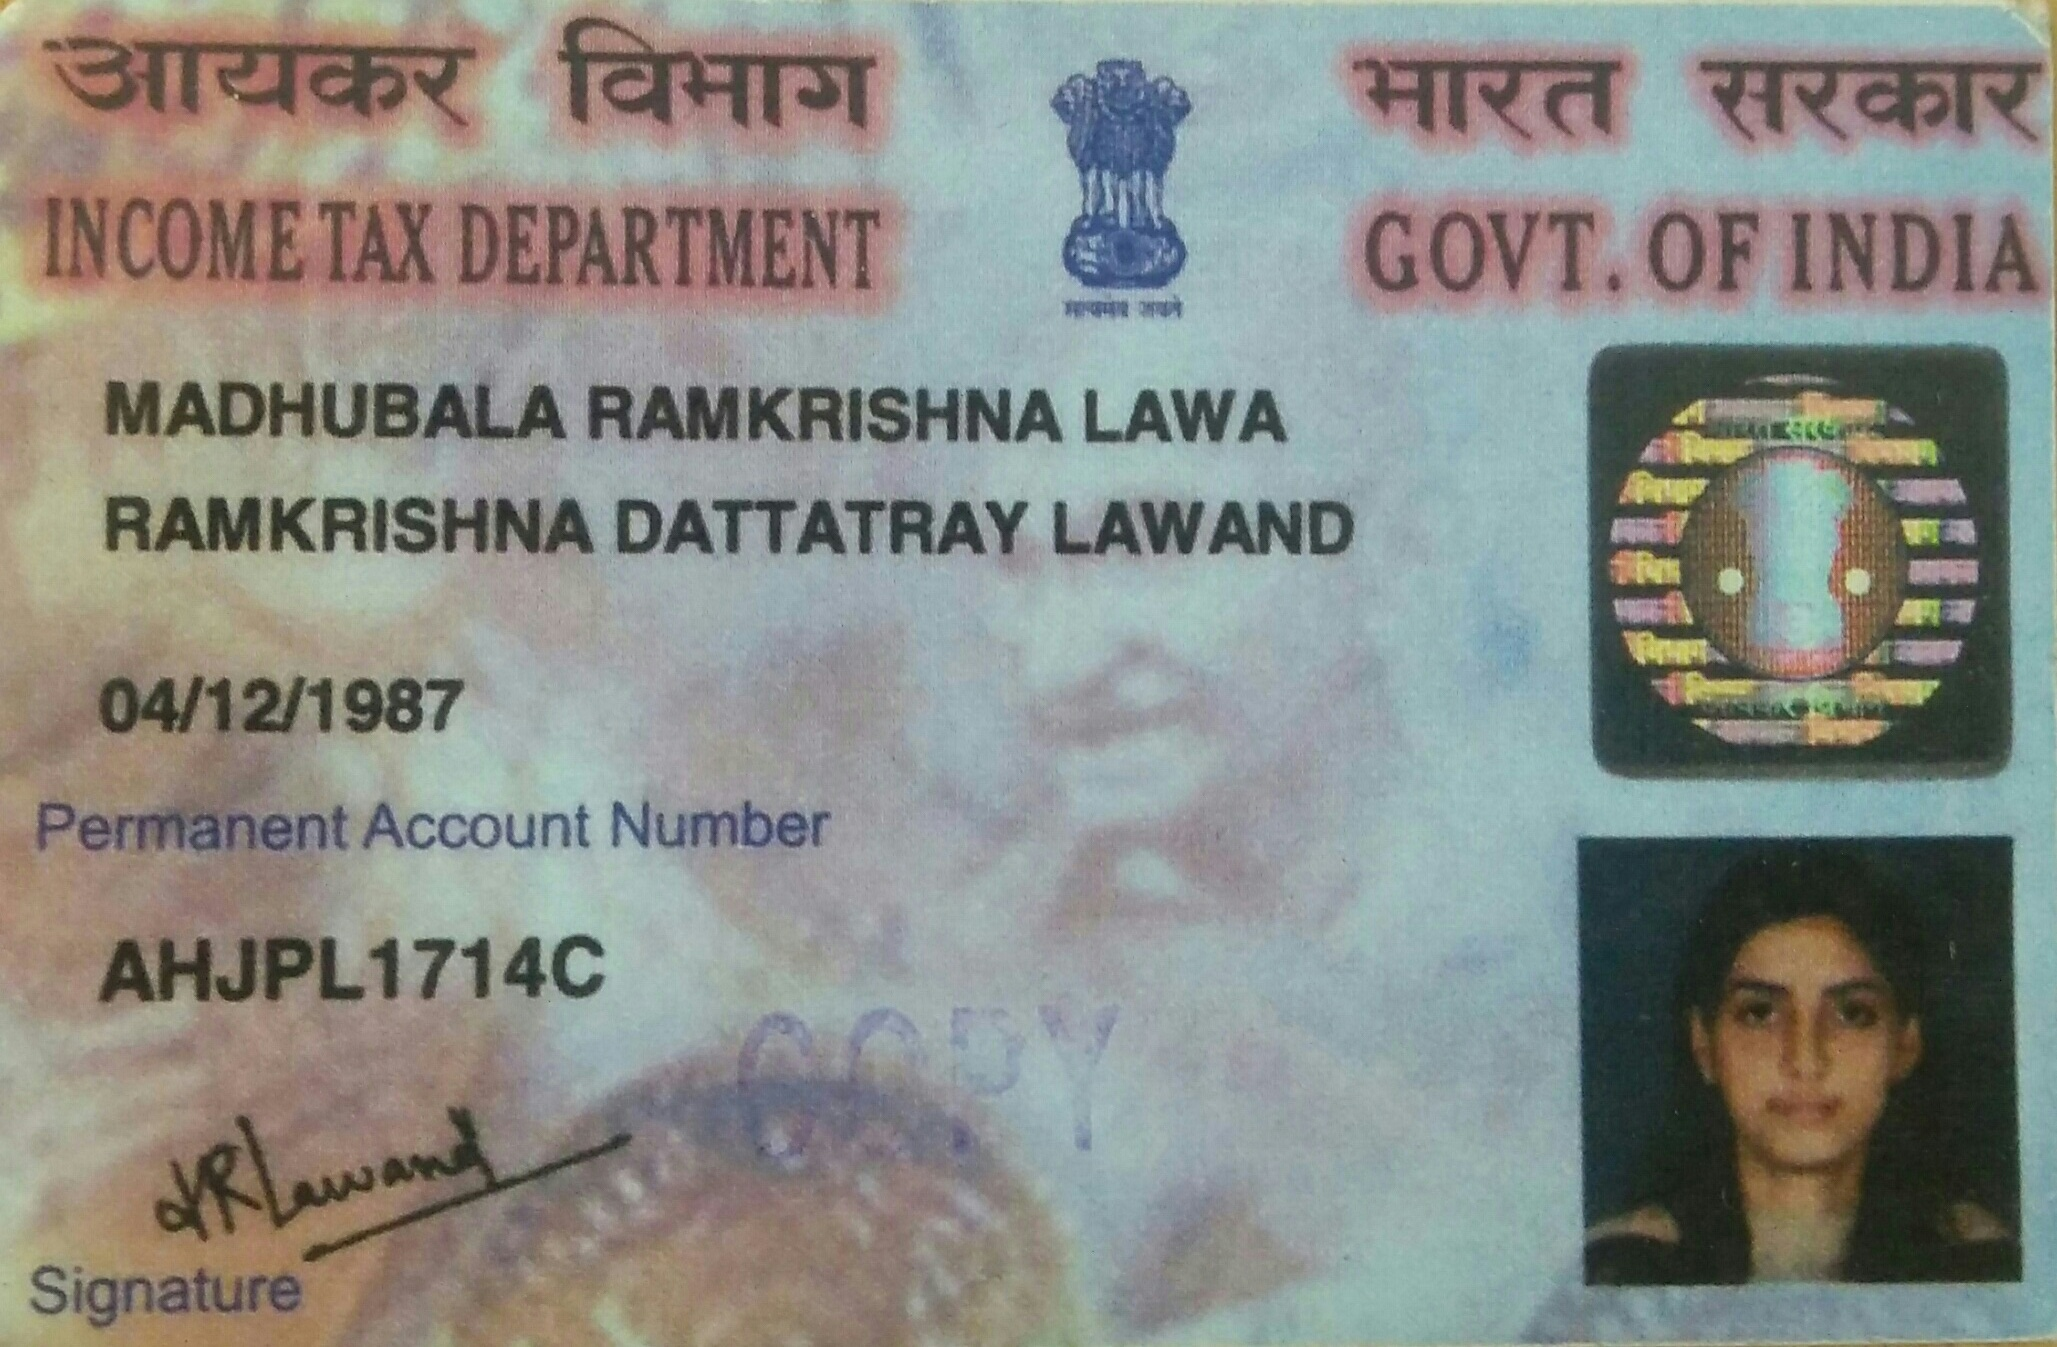

In [30]:
Image(filename = "./Test/attachments/IMG_20200116_112308_01_01_01.jpg", width=400, height=300)

In [31]:
result = model1.predict([prepare("./Test/attachments/IMG_20200116_112308_01_01_01.jpg")])
print(result[0])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[2.7319741e-02 5.7371486e-02 9.1379213e-01 6.0824220e-08 1.5165379e-03]
PAN :  91.38 %


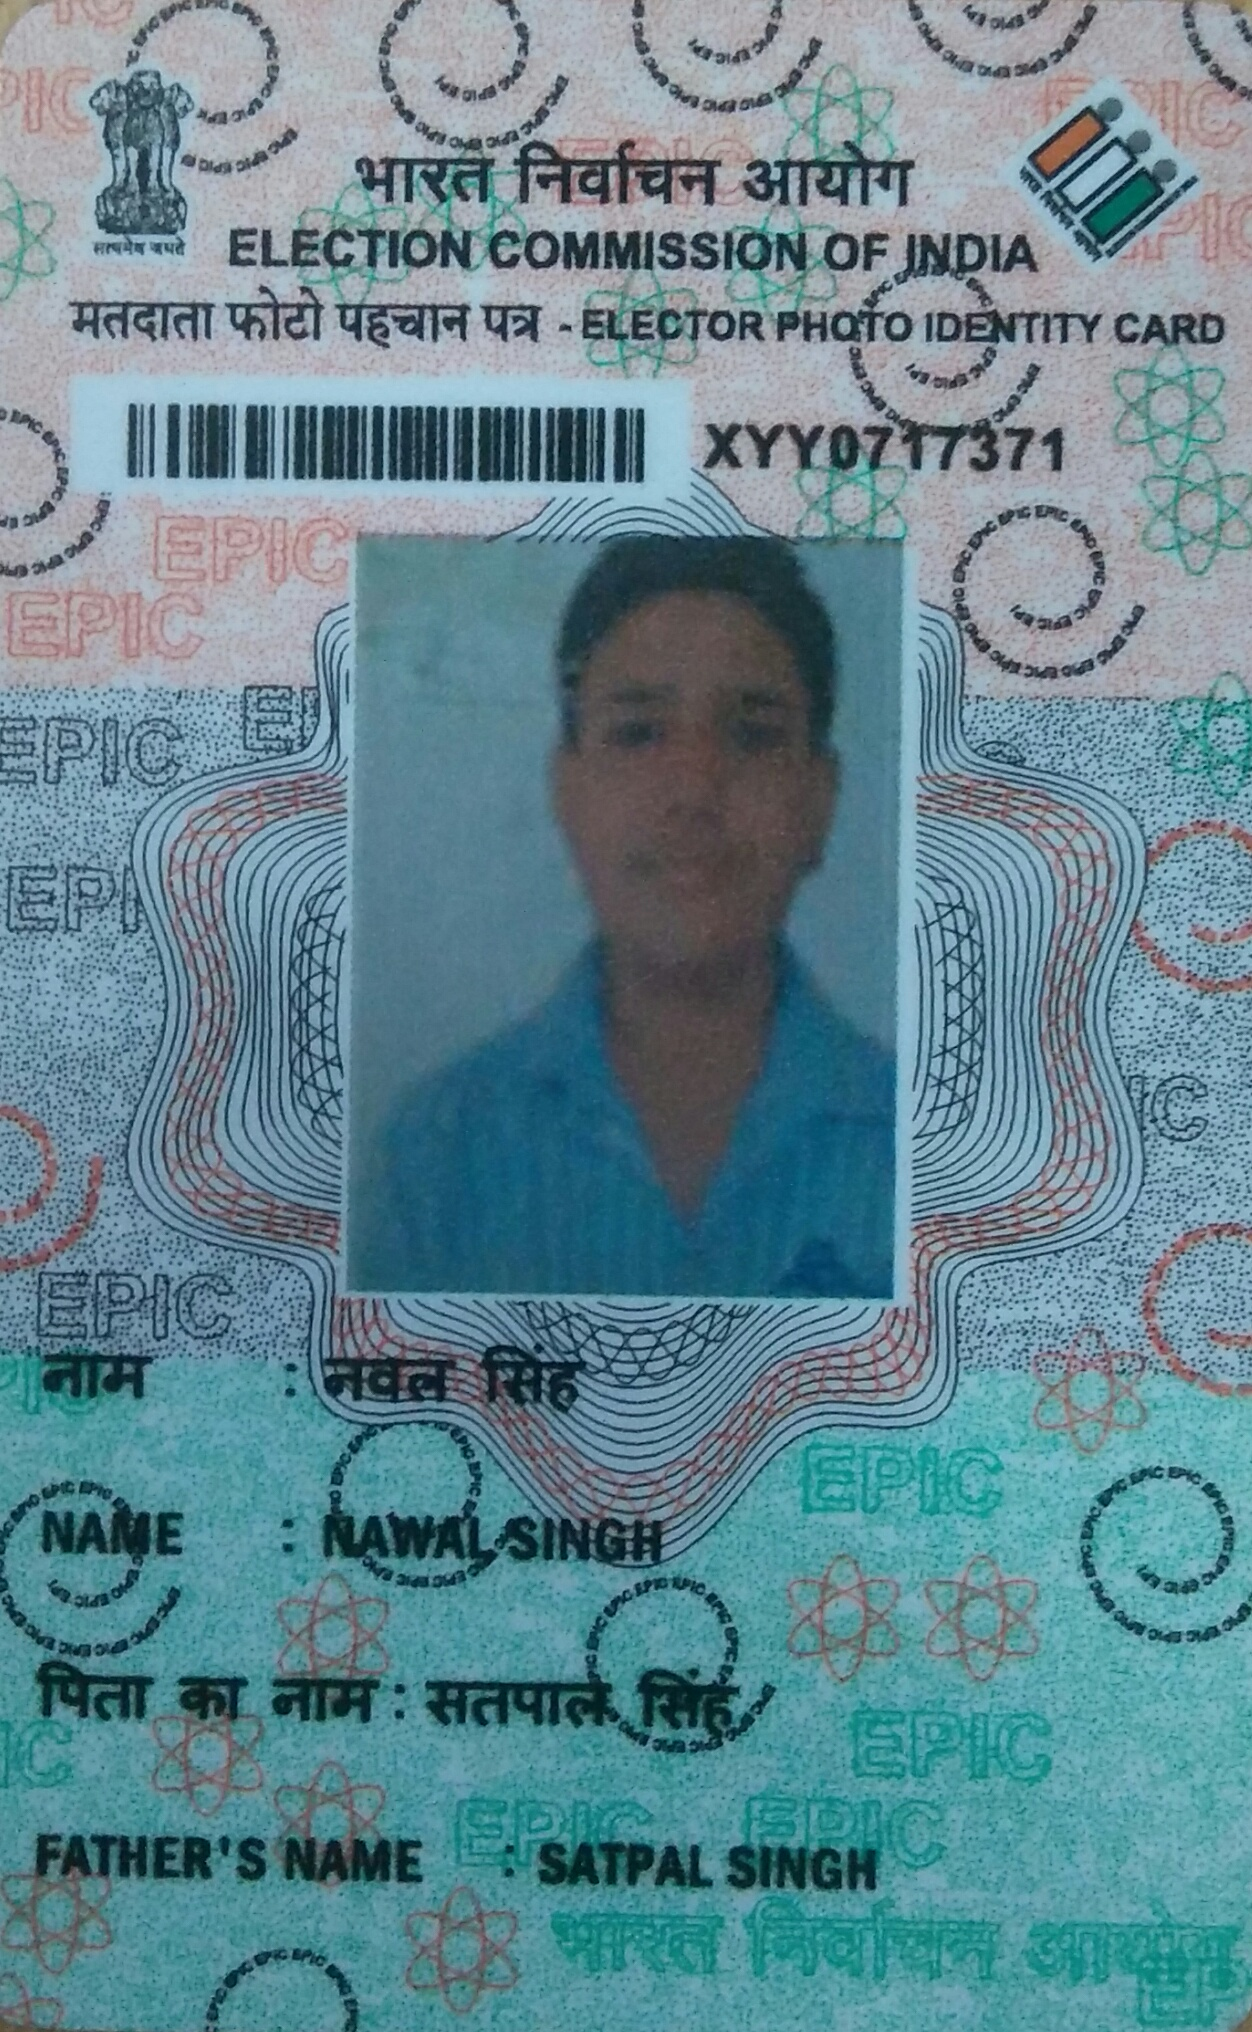

In [33]:
Image(filename = "./Test/attachments/IMG_20200116_163003_01.jpg", width=200, height=300)

In [34]:
result = model1.predict([prepare("./Test/attachments/IMG_20200116_163003_01.jpg")])
print(result[0])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[2.3828713e-07 7.2660850e-10 2.7359406e-11 1.0747553e-09 9.9999976e-01]
Voter ID :  100.0 %


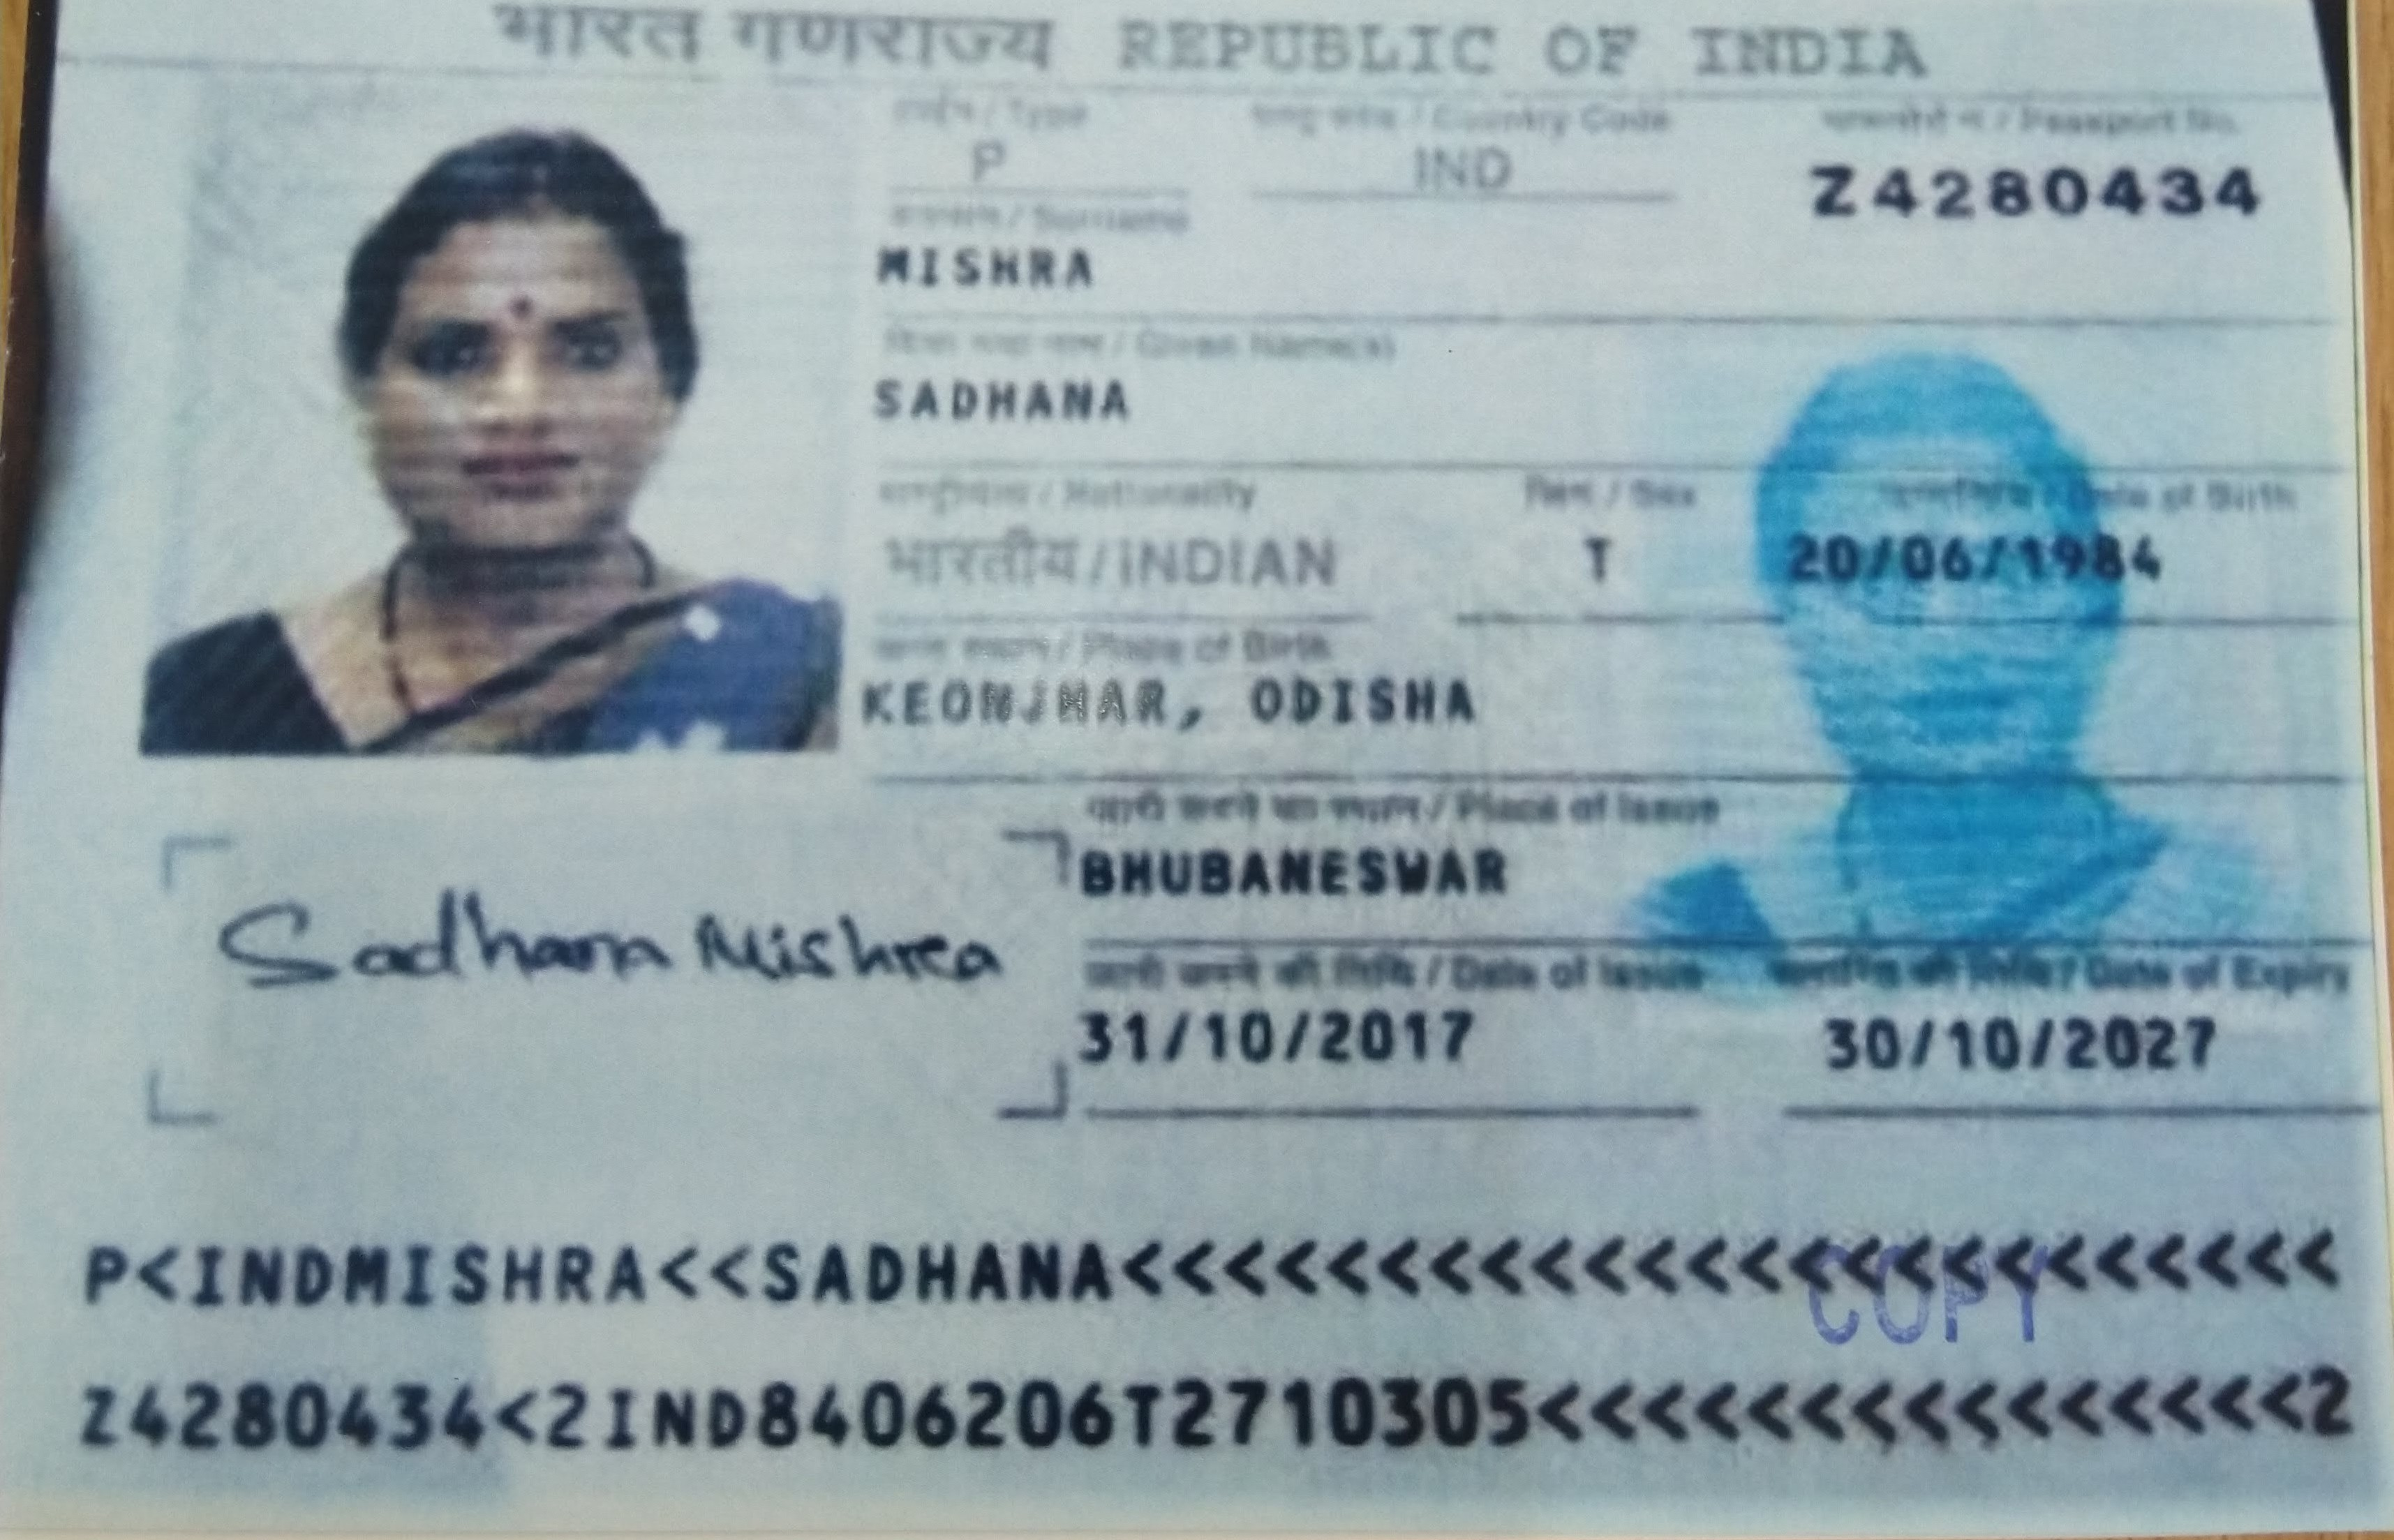

In [37]:
Image(filename = "./Test/INDIA_PASSPORT_FRONT_4.jpg", width=400, height=300)

In [38]:
result = model1.predict([prepare("./Test/INDIA_PASSPORT_FRONT_4.jpg")])
print(result[0])
print(Classes[np.argmax(result[0])], ": " , round((max(result[0])*100),2), "%")

[1.0498698e-04 2.6387318e-07 1.3230869e-04 9.9746394e-01 2.2984962e-03]
Passport :  99.75 %
